## Work
1. 請嘗試寫一個 callback 用來記錄各類別在訓練過程中，對驗證集的 True Positive 與 True Negative

In [1]:
import os
import keras

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\users\user\.conda\envs\tf113\lib\site-packages\tensorflo

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization

def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [33]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 30
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [34]:
#test
import numpy as np
print(np.logical_and([0,0,1,1,0], [0,0,1,1,1]))
print(np.sum(np.logical_and([0,0,1,1,0], [0,0,1,1,1])))

nnn=np.array([[2,5,3,9,7],[2,1,8,5,0]])
# np.argmax(nnn,axis=1)
nnn.argmax(axis=1)

[False False  True  True False]
2


array([3, 2], dtype=int64)

In [ ]:
# True Positive (TP):predict a label of 1 (positive), true label is 1.
TP = np.sum(np.logical_and(pred_labels == 1, true_labels == 1))
 
# True Negative (TN):predict a label of 0 (negative), true label is 0.
TN = np.sum(np.logical_and(pred_labels == 0, true_labels == 0))
 
# False Positive (FP):predict a label of 1 (positive),true label is 0.
FP = np.sum(np.logical_and(pred_labels == 1, true_labels == 0))
 
# False Negative (FN):predict a label of 0 (negative),true label is 1.
FN = np.sum(np.logical_and(pred_labels == 0, true_labels == 1))
 
print 'TP: %i, FP: %i, TN: %i, FN: %i' % (TP,FP,TN,FN)

In [35]:
# 載入 Callbacks
from keras.callbacks import Callback

# Record_fp_tp
class Record_tp_tn(Callback):
    """Code Here
    撰寫一個紀錄 ture positive 與 true negative 數量的 callbacks    
    """
    def on_train_begin(self, epoch, logs = {}):
        logs = logs or {}
        record_items = ["val_auc", "val_f1sc", "val_fp", "val_fn", "val_tp", "val_tn"]
        for i in record_items:
            if i not in self.params['metrics']:
                self.params['metrics'].append(i)
    def on_epoch_end(self, epoch, logs = {}, thres=0.5):
        logs = logs or {}
        y_true = self.validation_data[1].argmax(axis = 1)
        #after next line softmax predict 'y_pred return shape(10000,10)' with probability each row ex:[0.1,0.2,...0.1] len=10, stands for 0~9
        y_pred = self.model.predict(self.validation_data[0])
        #so have to find the max probability of each row reprensentsing predicting value
        y_pred=y_pred.argmax(axis = 1)
        
        #take 0,1 as example
        logs["val_tp"] = np.sum(np.logical_and(y_pred == 1, y_true == 1))
        logs["val_tn"] = np.sum(np.logical_and(y_pred == 0, y_true == 0))        
        #logs["val_f1sc"] = f1_score(y_true = y_true, y_pred = y_pred, average="weighted")
  
        print("y_true",y_true)
        print("y_pred",y_pred)
        print("sum y_pred",np.sum(y_pred),"y_pred shape",y_pred.shape,"y_true shape",y_true.shape)


    
        
rec_tptn = Record_tp_tn()

In [36]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()
optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

"""Code Here
將 callbacks 放入模型訓練流程中
"""
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True,
          callbacks=[rec_tptn])

# Collect results
train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]
train_acc = model.history.history["accuracy"]
valid_acc = model.history.history["val_accuracy"]

"""Code Here
將 tp/tn 從訓練完的模型中取出
"""
valid_tp = model.history.history["val_tp"]
valid_tn = model.history.history["val_tn"]


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024

50000/50000 [==============================] - 2s 36us/step - loss: 1.0068 - accuracy: 0.6574 - val_loss: 1.4278 - val_accuracy: 0.5041
y_true [3 8 8 ... 5 1 7]
y_pred [3 1 1 ... 2 5 7]
sum y_pred 45574 y_pred shape (10000,) y_true shape (10000,)
Epoch 28/30
50000/50000 [==============================] - 2s 36us/step - loss: 0.9900 - accuracy: 0.6636 - val_loss: 1.4296 - val_accuracy: 0.5030
y_true [3 8 8 ... 5 1 7]
y_pred [3 8 8 ... 2 5 7]
sum y_pred 46607 y_pred shape (10000,) y_true shape (10000,)
Epoch 29/30
50000/50000 [==============================] - 2s 36us/step - loss: 0.9739 - accuracy: 0.6692 - val_loss: 1.4325 - val_accuracy: 0.5025
y_true [3 8 8 ... 5 1 7]
y_pred [3 1 8 ... 2 5 7]
sum y_pred 46433 y_pred shape (10000,) y_true shape (10000,)
Epoch 30/30
50000/50000 [==============================] - 2s 36us/step - loss: 0.9564 - accuracy: 0.6774 - val_loss: 1.4388 - val_accuracy: 0.5031
y_true [3 8 8 ... 5 1 7]
y_pred [3 9 8 ... 2 5 7]
sum y_pred 47029 y_pred shape (10000,

In [37]:
#just test
_y_true__ =np.array([3, 0, 8, 5, 1, 0])
_y_pred__= np.array([5 ,0 ,8 , 5, 1, 0])
print(_y_true__ == 0)
print(_y_pred__ == 0)
print(_y_true__ == 1)
print(_y_pred__ == 1)
print(np.logical_and(_y_pred__ == 0, _y_true__ == 0))
print(np.sum(np.logical_and(_y_pred__ == 0, _y_true__ == 0)))
print(np.sum(np.logical_and(_y_pred__ == 1, _y_true__ == 1)))

[False  True False False False  True]
[False  True False False False  True]
[False False False False  True False]
[False False False False  True False]
[False  True False False False  True]
2
1


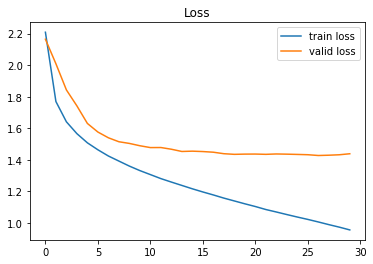

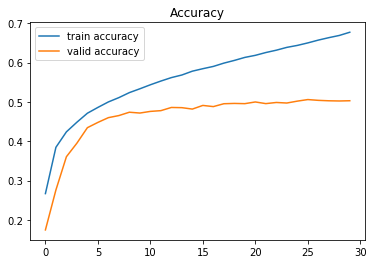

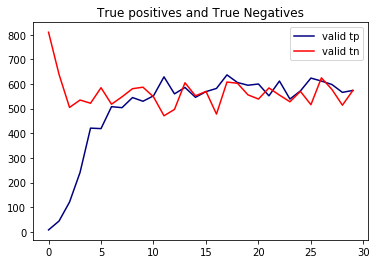

In [38]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(range(len(valid_tp)), valid_tp, label="valid tp", color="navy")
plt.plot(range(len(valid_tn)), valid_tn, label="valid tn", color="red")
plt.legend()
plt.title("True positives and True Negatives")
plt.show()
